In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time
import copy
# custom imports
import utils
import mcts
import train
from rtfm import featurizer as X

Using device cuda:0
Using device cuda:0


In [3]:
ucb_C = 1.0
discount = 0.997
episode_length = 16
max_actions = 5
num_simulations = 50
device = mcts.device
n_episodes = 2000
memory_size = 528
batch_size = 64

flags = utils.Flags(env="rtfm:groups_simple_stationary-v0")
gym_env = utils.create_env(flags)
featurizer = X.Render()
game_simulator = mcts.FullTrueSimulator(gym_env, featurizer)
value_net = mcts.FixedDynamicsValueNet_v1(gym_env).to(device)
#value_net = mcts.ValueMLP(gym_env).to(device)
optimizer = torch.optim.Adam(value_net.parameters(), lr=5e-3)
loss_fn = F.mse_loss
rb = train.ReplayBuffer(memory_size, discount)

In [4]:
training_dict = torch.load("training_dict_n_steps_boot")
object_ids=training_dict["object_ids"]
value_net=training_dict["value_net"]
rb=training_dict["rb"]
losses=training_dict["losses"]
mode_scores=training_dict["mode_scores"]

## Separate embeddings on value net

In [81]:
%%time
# More thourough test at the end to compare the 3 methods
scores = train.compare_modes(game_simulator, 
                               value_net, 
                               episode_length, 
                               ucb_C, 
                               discount, 
                               max_actions, 
                               num_simulations,
                               n_episodes=100
                              )
print("Average return in simulate mode: ", scores[0])
print("Average return in predict mode: ", scores[1])
print("Average return in simulate and predict mode: ", scores[2])
print("Average return in hybrid mode: ", scores[3])


Mode: simulate

██████
█ n !█
█   y█
█ @  █
█  ? █
██████


██████
█ n !█
█   y█
█ @  █
█  ? █
██████


██████
█ n !█
█   y█
█@   █
█  ? █
██████


██████
█ n !█
█@  y█
█    █
█  ? █
██████


██████
█ n !█
█@  y█
█    █
█  ? █
██████


██████
█ n !█
█ @ y█
█    █
█  ? █
██████


██████
█ n !█
█  @y█
█    █
█  ? █
██████


██████
█ n !█
█   @█
█    █
█  ? █
██████
grandmasters sword

██████
█ n @█
█    █
█    █
█  ? █
██████
grandmasters sword

Mode: predict

██████
█ n !█
█   y█
█ @  █
█  ? █
██████


██████
█ n !█
█ @ y█
█    █
█  ? █
██████


██████
█ @ !█
█   y█
█    █
█  ? █
██████
gleaming sword

██████
█@  !█
█   y█
█    █
█  ? █
██████
gleaming sword

██████
█   !█
█@  y█
█    █
█  ? █
██████
gleaming sword

██████
█   !█
█   y█
█@   █
█  ? █
██████
gleaming sword

██████
█   !█
█   y█
█@   █
█  ? █
██████
gleaming sword

██████
█   !█
█   y█
█@   █
█  ? █
██████
gleaming sword

██████
█   !█
█   y█
█@   █
█  ? █
██████
gleaming sword

██████
█   !█
█   y█
█@   █
█  ? █
██████


In [86]:
skip = False
if not skip:
    # Trying to see retraining it works better
    optimizer = torch.optim.Adam(value_net.parameters(), lr=1e-3)

    n_updates = 500
    losses = []
    for i in range(n_updates):
        frames, targets = rb.get_batch(64)
        reshaped_frames = {}
        for k in frames.keys():
            shape = frames[k].shape
            reshaped_frames[k] = frames[k].reshape(-1,*shape[2:])
        targets = targets.reshape(-1).to(device)
        values = value_net(reshaped_frames).squeeze(1)

        loss = loss_fn(values, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print("Update: %d - Loss: %.4f"%(i+1,loss.item()))
        losses.append(loss.item())

Update: 1 - Loss: 0.2406
Update: 2 - Loss: 0.2053
Update: 3 - Loss: 0.2245
Update: 4 - Loss: 0.2353
Update: 5 - Loss: 0.2126
Update: 6 - Loss: 0.2304
Update: 7 - Loss: 0.2145
Update: 8 - Loss: 0.2259
Update: 9 - Loss: 0.2097
Update: 10 - Loss: 0.2431
Update: 11 - Loss: 0.2264
Update: 12 - Loss: 0.2302
Update: 13 - Loss: 0.2153
Update: 14 - Loss: 0.2087
Update: 15 - Loss: 0.2057
Update: 16 - Loss: 0.2110
Update: 17 - Loss: 0.2282
Update: 18 - Loss: 0.2250
Update: 19 - Loss: 0.2337
Update: 20 - Loss: 0.2314
Update: 21 - Loss: 0.2268
Update: 22 - Loss: 0.2135
Update: 23 - Loss: 0.2258
Update: 24 - Loss: 0.2202
Update: 25 - Loss: 0.2272
Update: 26 - Loss: 0.2029
Update: 27 - Loss: 0.2026
Update: 28 - Loss: 0.2324
Update: 29 - Loss: 0.2115
Update: 30 - Loss: 0.2274
Update: 31 - Loss: 0.1946
Update: 32 - Loss: 0.2112
Update: 33 - Loss: 0.2147
Update: 34 - Loss: 0.2105
Update: 35 - Loss: 0.2247
Update: 36 - Loss: 0.1920
Update: 37 - Loss: 0.1956
Update: 38 - Loss: 0.2004
Update: 39 - Loss: 0.

Update: 319 - Loss: 0.0540
Update: 320 - Loss: 0.0365
Update: 321 - Loss: 0.0533
Update: 322 - Loss: 0.0464
Update: 323 - Loss: 0.0399
Update: 324 - Loss: 0.0420
Update: 325 - Loss: 0.0405
Update: 326 - Loss: 0.0462
Update: 327 - Loss: 0.0406
Update: 328 - Loss: 0.0437
Update: 329 - Loss: 0.0432
Update: 330 - Loss: 0.0381
Update: 331 - Loss: 0.0320
Update: 332 - Loss: 0.0420
Update: 333 - Loss: 0.0363
Update: 334 - Loss: 0.0492
Update: 335 - Loss: 0.0343
Update: 336 - Loss: 0.0313
Update: 337 - Loss: 0.0389
Update: 338 - Loss: 0.0394
Update: 339 - Loss: 0.0338
Update: 340 - Loss: 0.0336
Update: 341 - Loss: 0.0516
Update: 342 - Loss: 0.0385
Update: 343 - Loss: 0.0425
Update: 344 - Loss: 0.0299
Update: 345 - Loss: 0.0458
Update: 346 - Loss: 0.0438
Update: 347 - Loss: 0.0509
Update: 348 - Loss: 0.0403
Update: 349 - Loss: 0.0443
Update: 350 - Loss: 0.0418
Update: 351 - Loss: 0.0466
Update: 352 - Loss: 0.0393
Update: 353 - Loss: 0.0412
Update: 354 - Loss: 0.0351
Update: 355 - Loss: 0.0424
U

In [87]:
%%time
# More thourough test at the end to compare the 3 methods
scores = train.compare_modes(game_simulator, 
                               value_net, 
                               episode_length, 
                               ucb_C, 
                               discount, 
                               max_actions, 
                               num_simulations,
                               n_episodes=100
                              )
print("Average return in simulate mode: ", scores[0])
print("Average return in predict mode: ", scores[1])
print("Average return in simulate and predict mode: ", scores[2])
print("Average return in hybrid mode: ", scores[3])


Mode: simulate

██████
█ y@ █
█    █
█  n?█
█   !█
██████


██████
█ y@ █
█    █
█  n?█
█   !█
██████


██████
█ @  █
█    █
█  n?█
█   !█
██████
grandmasters sword

██████
█@   █
█    █
█  n?█
█   !█
██████
grandmasters sword

██████
█@   █
█    █
█  n?█
█   !█
██████
grandmasters sword

██████
█ @  █
█    █
█  n?█
█   !█
██████
grandmasters sword

██████
█    █
█ @  █
█  n?█
█   !█
██████
grandmasters sword

██████
█ @  █
█    █
█  n?█
█   !█
██████
grandmasters sword

██████
█@   █
█    █
█  n?█
█   !█
██████
grandmasters sword

██████
█@   █
█    █
█  n?█
█   !█
██████
grandmasters sword

██████
█@   █
█    █
█  n?█
█   !█
██████
grandmasters sword

██████
█ @  █
█    █
█  n?█
█   !█
██████
grandmasters sword

██████
█ @  █
█    █
█  n?█
█   !█
██████
grandmasters sword

██████
█    █
█ @  █
█  n?█
█   !█
██████
grandmasters sword

██████
█    █
█    █
█ @n?█
█   !█
██████
grandmasters sword

██████
█    █
█    █
█  n?█
█ @ !█
██████
grandmasters sword

██████
█    █
█    █
█  n?█

In [89]:
losses = torch.load("losses_Vboot1")

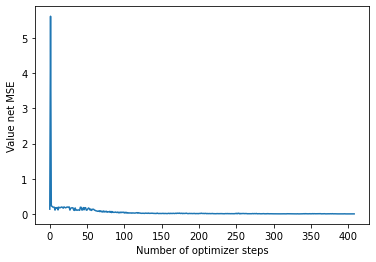

In [90]:
plt.plot(np.arange(len(losses)), losses)
plt.xlabel("Number of optimizer steps")
plt.ylabel("Value net MSE")
plt.show()

In [58]:
simulate_scores = [score[0] for score in mode_scores] 
predict_scores = [score[1] for score in mode_scores]
sim_and_pred_scores = [score[2] for score in mode_scores] 
hybrid_scores = [score[3] for score in mode_scores] 

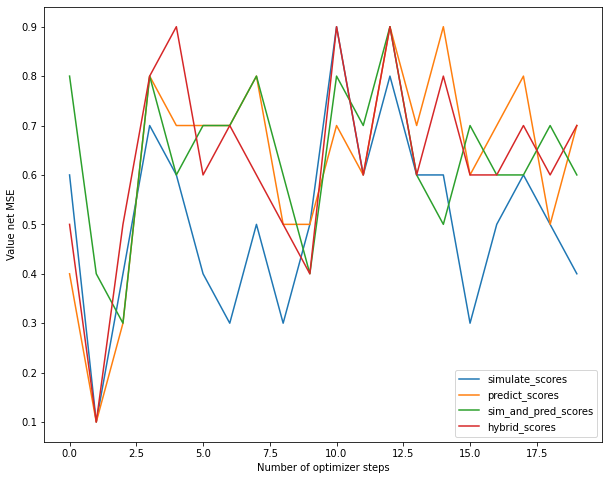

In [60]:
plt.figure(figsize=(10,8))
plt.plot(np.arange(len(mode_scores)), simulate_scores, label="simulate_scores")
plt.plot(np.arange(len(mode_scores)), predict_scores, label="predict_scores")
plt.plot(np.arange(len(mode_scores)), sim_and_pred_scores, label="sim_and_pred_scores")
plt.plot(np.arange(len(mode_scores)), hybrid_scores, label="hybrid_scores")
plt.legend()
plt.xlabel("Number of optimizer steps")
plt.ylabel("Value net MSE")
plt.show()

## Visual graphics for training data - double value net bootstrapping

In [9]:
# Value vs target hist on a batch
n_steps = 5
discount = 0.9
frames, targets = rb.get_batch(batch_size, n_steps, discount, value_net, device)
#reshaped_frames = {}
#for k in frames.keys():
#    shape = frames[k].shape
#    reshaped_frames[k] = frames[k].reshape(-1,*shape[2:])
targets = targets.reshape(-1).cpu().numpy()
with torch.no_grad():
    values = value_net(frames).squeeze(1).cpu().numpy()
diff = values - targets

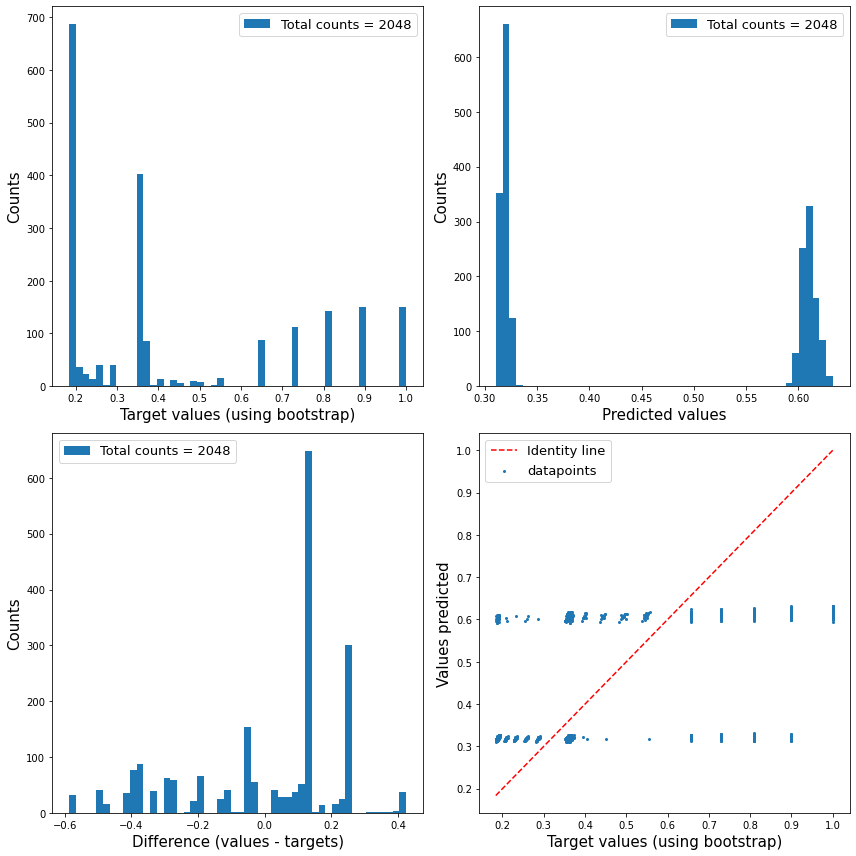

In [10]:
fig, ax = plt.subplots(2,2, figsize=(12,12))

# Targets distribution
ns, xs, _ = ax[0,0].hist(targets, bins=50, label="Total counts = %d"%len(targets))
ax[0,0].set_xlabel("Target values (using bootstrap)", fontsize=15)
ax[0,0].set_ylabel("Counts", fontsize=15)
ax[0,0].legend(fontsize=13)

# Values distribution
ns, xs, _ = ax[0,1].hist(values, bins=50, label="Total counts = %d"%len(values))
ax[0,1].set_xlabel("Predicted values", fontsize=15)
ax[0,1].set_ylabel("Counts", fontsize=15)
ax[0,1].legend(fontsize=13)

# Distribution of the difference
ns, xs, _ = ax[1,0].hist(diff, bins=50, label="Total counts = %d"%len(diff))
ax[1,0].set_xlabel("Difference (values - targets)", fontsize=15)
ax[1,0].set_ylabel("Counts", fontsize=15)
ax[1,0].legend(fontsize=13)

# Scatterplot targets (x) vs values (y)
m, M = targets.min(), targets.max()
x = np.linspace(m,M,100)
ax[1,1].scatter(targets, values, s=4, label='datapoints')
ax[1,1].plot(x,x, 'r--', label="Identity line")
ax[1,1].set_xlabel("Target values (using bootstrap)", fontsize=15)
ax[1,1].set_ylabel("Values predicted", fontsize=15)
ax[1,1].legend(fontsize=13)

plt.tight_layout()
plt.show()

## Visual graphics for training data - Value net bootstrapping

In [91]:
rb = torch.load("replay_buffer_Vboot1")

In [92]:
value_net = torch.load("value_net_Vboot1")

In [93]:
# Value vs target hist on a batch
frames, targets = rb.get_batch(64)
reshaped_frames = {}
for k in frames.keys():
    shape = frames[k].shape
    reshaped_frames[k] = frames[k].reshape(-1,*shape[2:])
targets = targets.reshape(-1).numpy()
with torch.no_grad():
    values = value_net(reshaped_frames).squeeze(1).cpu().numpy()
diff = values - targets

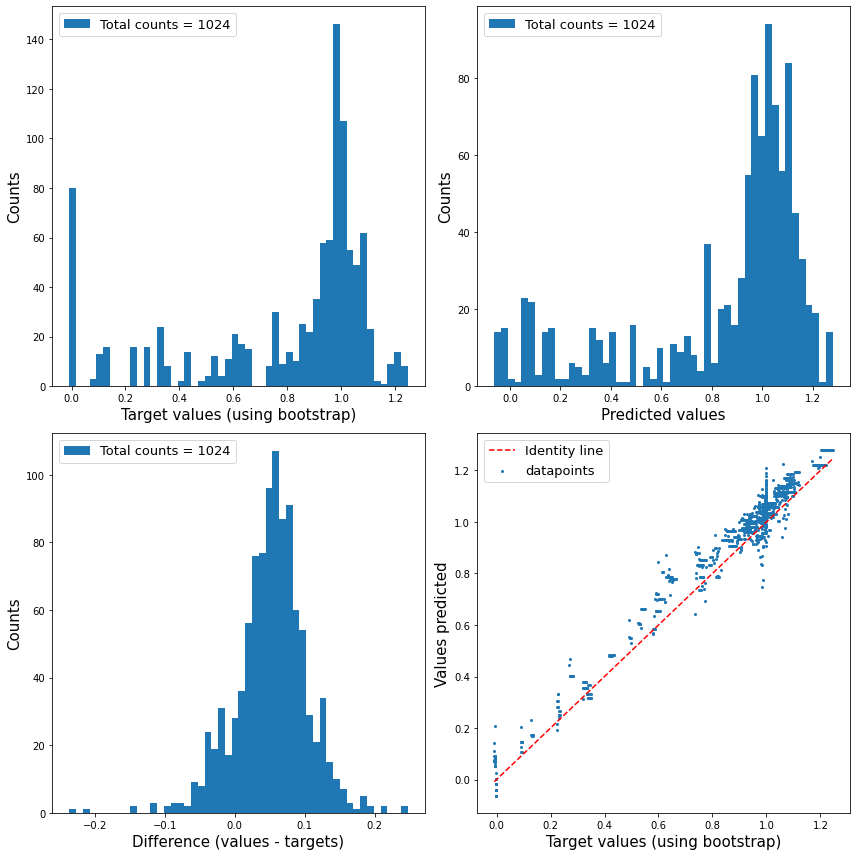

In [94]:
fig, ax = plt.subplots(2,2, figsize=(12,12))

# Targets distribution
ns, xs, _ = ax[0,0].hist(targets, bins=50, label="Total counts = %d"%len(targets))
ax[0,0].set_xlabel("Target values (using bootstrap)", fontsize=15)
ax[0,0].set_ylabel("Counts", fontsize=15)
ax[0,0].legend(fontsize=13)

# Values distribution
ns, xs, _ = ax[0,1].hist(values, bins=50, label="Total counts = %d"%len(values))
ax[0,1].set_xlabel("Predicted values", fontsize=15)
ax[0,1].set_ylabel("Counts", fontsize=15)
ax[0,1].legend(fontsize=13)

# Distribution of the difference
ns, xs, _ = ax[1,0].hist(diff, bins=50, label="Total counts = %d"%len(diff))
ax[1,0].set_xlabel("Difference (values - targets)", fontsize=15)
ax[1,0].set_ylabel("Counts", fontsize=15)
ax[1,0].legend(fontsize=13)

# Scatterplot targets (x) vs values (y)
m, M = targets.min(), targets.max()
x = np.linspace(m,M,100)
ax[1,1].scatter(targets, values, s=4, label='datapoints')
ax[1,1].plot(x,x, 'r--', label="Identity line")
ax[1,1].set_xlabel("Target values (using bootstrap)", fontsize=15)
ax[1,1].set_ylabel("Values predicted", fontsize=15)
ax[1,1].legend(fontsize=13)

plt.tight_layout()
plt.show()

## Visual data on MCTS estimates vs value net ones

In [64]:
def play_rollout_value_net(
        value_net,
        env,
        episode_length,
        ucb_C,
        discount,
        max_actions,
        num_simulations,
        mode="simulate",
        render = False,
        debug_render=False
    ):
    """
    W.r.t. version 0 it re-uses the information cached in the child node selected 
    """
    action_dict = {
        0:"Stay",
        1:"Up",
        2:"Down",
        3:"Left",
        4:"Right"
    }
    frame, valid_actions = env.reset()
    if render:
        env.render()
    total_reward = 0
    done = False
    new_root = None
    # variables used for training of value net
    pred_values = []
    root_values = []
    for i in range(episode_length):
        tree = mcts.ValueMCTS(frame, 
                         env, 
                         valid_actions, 
                         ucb_C, 
                         discount, 
                         max_actions, 
                         value_net,
                         render=debug_render, 
                         root=new_root
                        )
        if render:
            print("Performing MCTS step")
        root, info = tree.run(num_simulations, mode=mode)
        pred_value = value_net(root.frame).item()
        #print("pred_value: ", pred_value)
        pred_values.append(pred_value)
        #print("root_value: ", root.value())
        root_values.append(root.value())
        
        if render:
            train.show_root_summary(root, discount)
            print("Tree info: ", info)
        action = root.best_action(discount)
        if render:
            print("Action selected from MCTS: ", action, "({})".format(action_dict[action]))
        new_root = tree.get_subtree(action)
        frame, valid_actions, reward, done = env.step(action)
        
        if render:
            env.render()
            print("Reward received: ", reward)
            print("Done: ", done)
        total_reward += reward
        if done:
            frame, valid_actions = env.reset()
            if render:
                print("\nNew episode begins.")
                env.render()
            done = False
            new_root = None

    return pred_values, root_values

In [65]:
episode_length_1 = 200
pred_values, root_values = play_rollout_value_net(value_net,
                                                game_simulator,
                                                episode_length_1,
                                                ucb_C,
                                                discount,
                                                max_actions,
                                                num_simulations,
                                                mode="predict",
                                                )

In [66]:
pred_values = np.array(pred_values)
root_values = np.array(root_values)
diff = pred_values - root_values

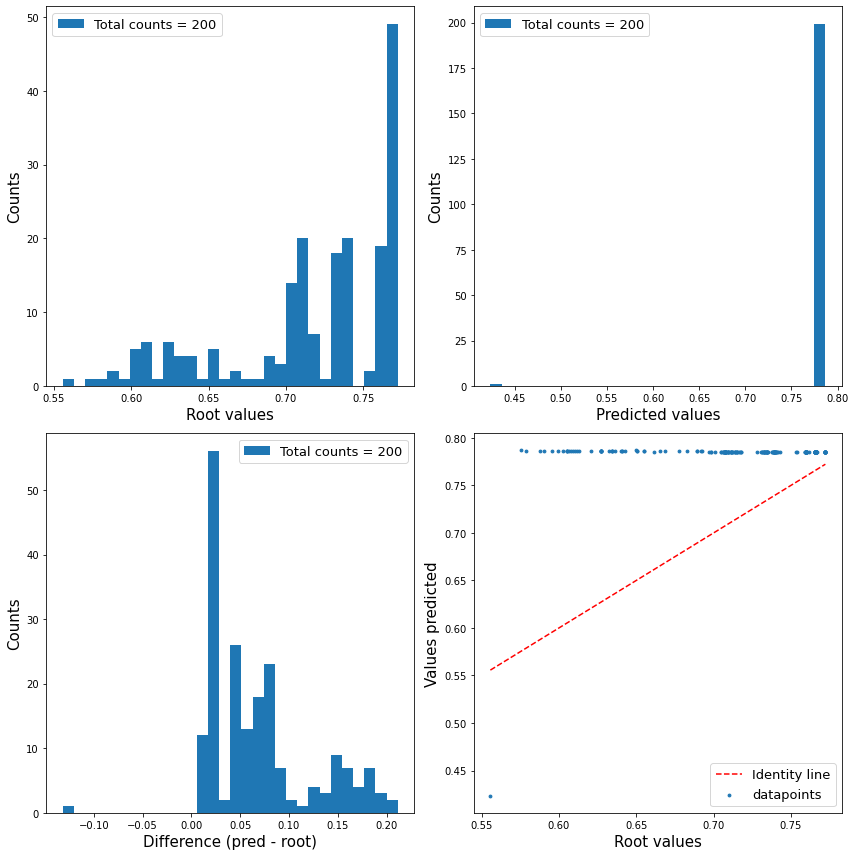

In [67]:
fig, ax = plt.subplots(2,2, figsize=(12,12))

# Targets distribution
ns, xs, _ = ax[0,0].hist(root_values, bins=30, label="Total counts = %d"%len(root_values))
ax[0,0].set_xlabel("Root values", fontsize=15)
ax[0,0].set_ylabel("Counts", fontsize=15)
ax[0,0].legend(fontsize=13)

# Values distribution
ns, xs, _ = ax[0,1].hist(pred_values, bins=30, label="Total counts = %d"%len(pred_values))
ax[0,1].set_xlabel("Predicted values", fontsize=15)
ax[0,1].set_ylabel("Counts", fontsize=15)
ax[0,1].legend(fontsize=13)

# Distribution of the difference
ns, xs, _ = ax[1,0].hist(diff, bins=30, label="Total counts = %d"%len(diff))
ax[1,0].set_xlabel("Difference (pred - root)", fontsize=15)
ax[1,0].set_ylabel("Counts", fontsize=15)
ax[1,0].legend(fontsize=13)

# Scatterplot targets (x) vs values (y)
m, M = root_values.min(), root_values.max()
x = np.linspace(m,M,100)
ax[1,1].scatter(root_values, pred_values, s=8, label='datapoints')
ax[1,1].plot(x,x, 'r--', label="Identity line")
ax[1,1].set_xlabel("Root values", fontsize=15)
ax[1,1].set_ylabel("Values predicted", fontsize=15)
ax[1,1].legend(fontsize=13)

plt.tight_layout()
plt.show()

## On-trajectory debug and analysis

In [95]:
verbose = False
vprint = print if verbose else lambda *args, **kwargs: None

In [96]:
action_dict = {
        0:"Stay",
        1:"Up",
        2:"Down",
        3:"Left",
        4:"Right"
    }

In [97]:
def debug_run(tree, num_simulations, mode="simulate"):
    """
    Runs num_simulations searches starting from the root node corresponding to the internal
    state of the simulator given during initialization.
    Returns the root node and an extra_info dictionary
    """
    if tree.root is None:
        tree.root = mcts.ValueNode()
        tree.root.expand(
            tree.root_frame,
            tree.valid_actions,
            0, # reward to get to root
            False, # terminal node
            tree.simulator # state of the simulator at the root node 
        )
        # not sure about this
        tree.root.visit_count += 1

    max_tree_depth = 0
    root = tree.root
    for n in range(num_simulations):
        ### Start of a simulation/search ###
        vprint("\nSimulation %d started."%(n+1))
        node = root
        # make sure that the simulator internal state is reset to the original one
        tree.simulator.load_state_dict(root.simulator_dict)
        search_path = [node]
        current_tree_depth = 0
        if tree.render:
            node.render(tree.simulator)
        ### Selection phase until leaf node is reached ###
        while node.expanded or (current_tree_depth<self.max_actions):
            current_tree_depth += 1
            action, node = tree.select(node)
            if tree.render and node.expanded:
                node.render(tree.simulator)
            vprint("Current tree depth: ", current_tree_depth)
            vprint("Action selected: %d (%s)"%(action, action_dict[action]))
            vprint("Child node expanded: ", node.expanded)
            if node.expanded:
                vprint("Child node terminal: ", node.terminal)
            if node.expanded or node.terminal:
                search_path.append(node)
                if node.terminal:
                    break
            else:
                break

        ### Expansion of leaf node (if not terminal)###
        vprint("Expansion phase started")
        if not node.terminal:
            parent = search_path[-1] # last expanded node on the search path
            node = tree.expand(node, parent, action)
            if tree.render:
                node.render(tree.simulator)
            search_path.append(node)

        ### Simulation phase for self.max_actions - current_tree_depth steps ###
        vprint("Value prediction/simulation phase started")
        simulated_value = tree.simulate(node, current_tree_depth)
        predicted_value = tree.predict(node)
        if mode == "simulate":
            value = simulated_value
        elif mode == "predict":
            value = predicted_value
        else:
            raise Exception("Unkown mode")
        vprint("Simulated value: ", simulated_value)
        vprint("Predicted value: ", predicted_value)
            
        ### Backpropagation of the leaf node value along the seach_path ###
        vprint("Backpropagation phase started")
        tree.backprop(search_path, value)

        max_tree_depth = max(max_tree_depth, current_tree_depth)
        vprint("Simulation %d done."%(n+1))
    extra_info = {
        "max_tree_depth": max_tree_depth
    }
    # just a check to see if root works as a shallow copy of self.root
    assert root.visit_count == tree.root.visit_count, "self.root not updated during search"

    # make sure that the simulator internal state is reset to the original one
    tree.simulator.load_state_dict(root.simulator_dict)
    return root, extra_info

In [98]:
def play_episode_value_net(
    value_net,
    env,
    episode_length,
    ucb_C,
    discount,
    max_actions,
    num_simulations,
    mode="simulate",
    render = False,
    debug_render=False
):
    """
    W.r.t. version 0 it re-uses the information cached in the child node selected 
    """
    
    frame, valid_actions = env.reset()
    if render:
        env.render()
    total_reward = 0
    done = False
    new_root = None
    # variables used for training of value net
    frame_lst = [frame]
    reward_lst = []
    done_lst = []
    for i in range(episode_length):
        predict_tree = mcts.ValueMCTS(frame, 
                         env, 
                         valid_actions, 
                         ucb_C, 
                         discount, 
                         max_actions, 
                         value_net,
                         render=debug_render, 
                         root=new_root
                        )
        simulate_tree = mcts.ValueMCTS(frame, 
                         env, 
                         valid_actions, 
                         ucb_C, 
                         discount, 
                         max_actions, 
                         value_net,
                         render=debug_render, 
                         root=new_root
                        )
        
        """predict_tree_half = mcts.ValueMCTS(frame, 
                         env, 
                         valid_actions, 
                         ucb_C/2, 
                         discount, 
                         max_actions, 
                         value_net,
                         render=debug_render, 
                         root=new_root
                        )
        simulate_tree_half = mcts.ValueMCTS(frame, 
                         env, 
                         valid_actions, 
                         ucb_C/2, 
                         discount, 
                         max_actions, 
                         value_net,
                         render=debug_render, 
                         root=new_root
                        )"""
        print("Performing MCTS step")
        
        simulate_root, info = debug_run(simulate_tree, num_simulations, mode="simulate")
        print("\nRoot from simulate method")
        mcts.show_root_summary(simulate_root, discount)
        print("Tree info: ", info)
        
        predict_root, info = debug_run(predict_tree, num_simulations, mode="predict")
        print("\nRoot from predict method")
        train.show_root_summary(predict_root, discount)
        print("Tree info: ", info)
        
        """predict_root_half, info = debug_run(predict_tree_half, num_simulations, mode="predict")
        print("\nRoot from predict method (half C)")
        mcts.show_root_summary(predict_root_half, discount)
        print("Tree info: ", info)
        
        simulate_root_half, info = debug_run(simulate_tree_half, num_simulations, mode="simulate")
        print("\nRoot from simulate method (half C)")
        mcts.show_root_summary(simulate_root_half, discount)
        print("Tree info: ", info)"""
        
        root = simulate_root
        tree = simulate_tree
        
        action = root.best_action(discount)
        print("\nWith simulate method we select: ", action, "({})".format(action_dict[action]))
        predict_action = predict_root.best_action(discount)
        print("With predict method we would select: ", predict_action, "({})".format(action_dict[predict_action]))
        #half_a_sim = simulate_root_half.best_action(discount)
        #print("With simulate (half C) method we select: ", half_a_sim, "({})".format(action_dict[half_a_sim]))
        #half_a_pred = predict_root_half.best_action(discount)
        #print("With predict (half C) method we would select: ", half_a_pred, "({})".format(action_dict[half_a_pred]))
        #new_root = tree.get_subtree(action)
        new_root = None ### Pay attention to this !! 
        frame, valid_actions, reward, done = env.step(action)
        
        
        frame_lst.append(frame)
        reward_lst.append(reward)
        done_lst.append(done)
        
        if render:
            env.render()
        #print("Reward received: ", reward)
        #print("Done: ", done)
        total_reward += reward
        if done:
            break
    return total_reward, frame_lst, reward_lst, done_lst

In [100]:
import train

Using device cuda:0


In [101]:
total_reward, frame_lst, reward_lst, done_lst = play_episode_value_net(value_net,
                                                                        game_simulator,
                                                                        episode_length,
                                                                        ucb_C,
                                                                        discount,
                                                                        max_actions,
                                                                        num_simulations,
                                                                        mode="predict",
                                                                        render=True
                                                                        )


██████
█ @? █
█   !█
█  y █
█n   █
██████

Performing MCTS step

Root from simulate method
Action  Stay : Q-value=-0.298 - Visit counts=10
Action  Down : Q-value=-0.149 - Visit counts=20
Action  Left : Q-value=-0.175 - Visit counts=17
Action  Right : Q-value=-1.000 - Visit counts=3
Tree info:  {'max_tree_depth': 4}

Root from predict method
Action  Stay : Q-value=0.418 - Visit counts=10
Action  Down : Q-value=0.613 - Visit counts=19
Action  Left : Q-value=0.618 - Visit counts=20
Action  Right : Q-value=-1.000 - Visit counts=1
Tree info:  {'max_tree_depth': 4}

With simulate method we select:  2 (Down)
With predict method we would select:  3 (Left)

██████
█  ? █
█ @ !█
█  y █
█n   █
██████

Performing MCTS step

Root from simulate method
Action  Stay : Q-value=-0.248 - Visit counts=8
Action  Up : Q-value=-0.249 - Visit counts=8
Action  Down : Q-value=-0.058 - Visit counts=17
Action  Left : Q-value=-0.066 - Visit counts=15
Action  Right : Q-value=-0.997 - Visit counts=2
Tree info:  {'m

## Analysing the value net based on some states

Note: is important to save and load the gym_env with which the network has been trained, because otherwise there might be different objects to the one seen in the training set.

In [11]:
def distance_from_target(name_frame):
    try:
        y_a, x_a = torch.nonzero(name_frame[:,:,0,0] == object_ids["agent"])[0]
        y_t, x_t = torch.nonzero(name_frame[:,:,0,0] == object_ids["target_monster"])[0]
        d = torch.abs(y_a - y_t) + torch.abs(x_a - x_t)
        return d
    except:
        return None

In [12]:
def render_frame(name_frame, object_ids):
    wall_ids = 3
    
    W = H = name_frame.shape[0]
    empty_row = [" " for _ in range(W)]
    representation = np.array([empty_row for _ in range(H)])
    
    try:
        y, x = torch.nonzero(name_frame[:,:,0,0] == object_ids["agent"])[0]
        representation[y, x] = "@"
    except:
        pass
    
    try:
        y, x = torch.nonzero(name_frame[:,:,0,0] == object_ids["target_monster"])[0]
        representation[y, x] = "!"
    except:
        pass
    
    try:
        y, x = torch.nonzero(name_frame[:,:,0,0] == object_ids["distractor_monster"])[0]
        representation[y, x] = "?"
    except:
        pass
    
    try:
        y, x = torch.nonzero(name_frame[:,:,0,0] == object_ids["yes_item"])[0]
        representation[y, x] = "y"
    except:
        pass
    
    try:
        y, x = torch.nonzero(name_frame[:,:,0,0] == object_ids["no_item"])[0]
        representation[y, x] = "n"
    except:
        pass

    try:
        positions = torch.nonzero(name_frame[:,:,0,0] == wall_ids)
        for y,x in positions:
            representation[y, x] = u"\u2588"
    except:
        pass
    
    char_repr = ""
    for r in representation:
        for r_i in r:
            char_repr += r_i
        char_repr +="\n"
    print(char_repr)

In [13]:
def analyse_d_states(frames, distances, d, object_ids, render=True):
    mask = (distances == d)
    states = frames["name"][mask]
    inventories = frames["inv"][mask]
    
    empty_inv = []
    yes_inv = []
    no_inv = []
    for i, f in enumerate(states):
        if render:
            print("\n\n")
            render_frame(f, object_ids)
        inv = inventories[i,0]
        if inv == 0:
            empty_inv.append(i)
            if render:
                print("Inv: empty")
        if inv == object_ids["yes_item"]:
            yes_inv.append(i)
            if render:
                print("Inv: yes item")
        if inv == object_ids["no_item"]:
            no_inv.append(i)
            if render:
                print("Inv: no item")
                
    empty_inv = np.array(empty_inv)
    yes_inv = np.array(yes_inv)
    no_inv = np.array(no_inv)
    inv_dict = dict(empty_inv=empty_inv, yes_inv=yes_inv, no_inv=no_inv)
    return states, inventories, mask, inv_dict

In [14]:
def render_states(states, values, targets, inv_dict, object_ids, render=False):
    means = {}
    devs = {}
    
    empty_inv_states = states[inv_dict["empty_inv"]]
    empty_inv_values = values[inv_dict["empty_inv"]]
    empty_inv_targets = targets[inv_dict["empty_inv"]]
    means["empty_values"] = empty_inv_values.mean()
    means["empty_targets"] = empty_inv_targets.mean()
    devs["empty_values"] = empty_inv_values.std()
    devs["empty_targets"] = empty_inv_targets.std()
    
    print("Rendering states with empty inventory")
    print("Mean predicted value: %.2f +/- %.2f"%(means["empty_values"],devs["empty_values"]))
    print("Mean target value: %.2f +/- %.2f"%(means["empty_targets"],devs["empty_targets"]))
    if render:
        for i, s in enumerate(empty_inv_states):
            print("\n\n")
            render_frame(s, object_ids)
            print("Inv: empty")
            print("Predicted value: %.4f"%empty_inv_values[i])
            print("Target value:    %.4f"%empty_inv_targets[i])
    print("-"*40)
    
    yes_inv_states = states[inv_dict["yes_inv"]]
    yes_inv_values = values[inv_dict["yes_inv"]]
    yes_inv_targets = targets[inv_dict["yes_inv"]]
    means["yes_values"] = yes_inv_values.mean()
    means["yes_targets"] = yes_inv_targets.mean()
    devs["yes_values"] = yes_inv_values.std()
    devs["yes_targets"] = yes_inv_targets.std()
    
    print("Rendering states with correct item in inventory")
    print("Mean predicted value: %.2f +/- %.2f"%(means["yes_values"],devs["yes_values"]))
    print("Mean target value: %.2f +/- %.2f"%(means["yes_targets"],devs["yes_targets"]))
    if render:
        for i, s in enumerate(yes_inv_states):
            print("\n\n")
            render_frame(s, object_ids)
            print("Inv: yes item")
            print("Predicted value: %.4f"%yes_inv_values[i])
            print("Target value:    %.4f"%yes_inv_targets[i])
    print("-"*40)
    
    no_inv_states = states[inv_dict["no_inv"]]
    no_inv_values = values[inv_dict["no_inv"]]
    no_inv_targets = targets[inv_dict["no_inv"]]
    means["no_values"] = no_inv_values.mean()
    means["no_targets"] = no_inv_targets.mean()
    devs["no_values"] = no_inv_values.std()
    devs["no_targets"] = no_inv_targets.std()
    
    print("Rendering states with wrong item in inventory")
    print("Mean predicted value: %.2f +/- %.2f"%(means["no_values"],devs["no_values"]))
    print("Mean target value: %.2f +/- %.2f"%(means["no_targets"],devs["no_targets"]))
    if render:
        for i, s in enumerate(no_inv_states):
            print("\n\n")
            render_frame(s, object_ids)
            print("Inv: no item")
            print("Predicted value: %.4f"%no_inv_values[i])
            print("Target value:    %.4f"%no_inv_targets[i])
    print("-"*40)
    
    return means, devs

In [77]:
def full_distance_analysis(frames, targets, value_net, distance, object_ids):
    reshaped_frames = {}
    for k in frames.keys():
        shape = frames[k].shape
        reshaped_frames[k] = frames[k].reshape(-1,*shape[2:])

    distances = []
    for t in range(len(reshaped_frames["name"])):
        d = distance_from_target(reshaped_frames["name"][t])
        if d is None:
            d = torch.tensor([0.]).float()
        else:
            d = torch.tensor([d]).float()
        distances.append(d)
    distances = torch.cat(distances, axis=0)

    targets = targets.reshape(-1).numpy()

    states, inventories, mask, inv_dict = analyse_d_states(reshaped_frames, distances, distance, object_ids, render=False)
    masked_target = targets[mask]
    masked_frames = {}
    for k in reshaped_frames.keys():
        masked_frames[k] = reshaped_frames[k][mask]
    with torch.no_grad():
        masked_values = value_net(masked_frames).squeeze(1).cpu().numpy()
    means, devs = render_states(states, masked_values, masked_target, inv_dict, object_ids)
    return means, devs

In [ ]:
def full_distance_analysis_v1(frames, targets, value_net, distance, object_ids):

    distances = []
    for t in range(len(reshaped_frames["name"])):
        d = distance_from_target(reshaped_frames["name"][t])
        if d is None:
            d = torch.tensor([0.]).float()
        else:
            d = torch.tensor([d]).float()
        distances.append(d)
    distances = torch.cat(distances, axis=0)

    targets = targets.reshape(-1).numpy()

    states, inventories, mask, inv_dict = analyse_d_states(reshaped_frames, distances, distance, object_ids, render=False)
    masked_target = targets[mask]
    masked_frames = {}
    for k in reshaped_frames.keys():
        masked_frames[k] = reshaped_frames[k][mask]
    with torch.no_grad():
        masked_values = value_net(masked_frames).squeeze(1).cpu().numpy()
    means, devs = render_states(states, masked_values, masked_target, inv_dict, object_ids)
    return means, devs

In [78]:
frames, targets = rb.get_batch(256)
value_means = np.zeros((5, 3))
value_devs = np.zeros((5, 3))
target_means = np.zeros((5, 3))
target_devs = np.zeros((5, 3))

for distance in range(0,5):
    print("\nDistance from target: ", distance+1)
    means, devs = full_distance_analysis(frames, targets, value_net, distance+1, object_ids)
    
    value_means[distance,0] = means["empty_values"]
    value_means[distance,1] = means["yes_values"]
    value_means[distance,2] = means["no_values"]
    target_means[distance,0] = means["empty_targets"]
    target_means[distance,1] = means["yes_targets"]
    target_means[distance,2] = means["no_targets"]
    value_devs[distance,0] = devs["empty_values"]
    value_devs[distance,1] = devs["yes_values"]
    value_devs[distance,2] = devs["no_values"]
    target_devs[distance,0] = devs["empty_targets"]
    target_devs[distance,1] = devs["yes_targets"]
    target_devs[distance,2] = devs["no_targets"]



Distance from target:  1
Rendering states with empty inventory
Mean predicted value: 0.43 +/- 0.01
Mean target value: 0.55 +/- 0.49
----------------------------------------
Rendering states with correct item in inventory
Mean predicted value: 0.79 +/- 0.01
Mean target value: 1.00 +/- 0.00
----------------------------------------
Rendering states with wrong item in inventory
Mean predicted value: 0.39 +/- 0.01
Mean target value: 0.71 +/- 0.45
----------------------------------------

Distance from target:  2
Rendering states with empty inventory
Mean predicted value: 0.42 +/- 0.01
Mean target value: 0.48 +/- 0.49
----------------------------------------
Rendering states with correct item in inventory
Mean predicted value: 0.79 +/- 0.01
Mean target value: 0.93 +/- 0.26
----------------------------------------
Rendering states with wrong item in inventory
Mean predicted value: 0.38 +/- 0.01
Mean target value: 0.41 +/- 0.49
----------------------------------------

Distance from target:  

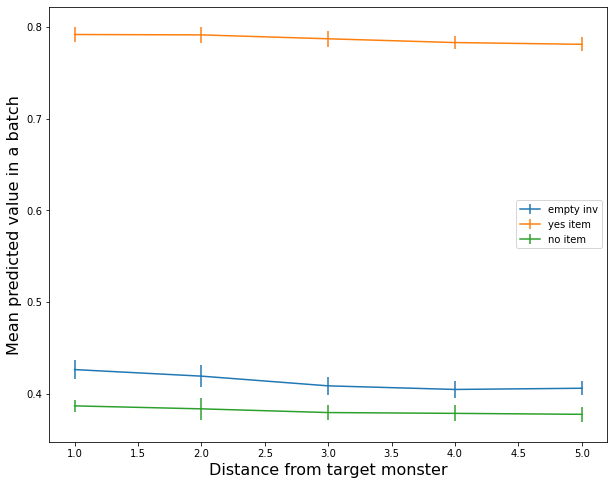

In [79]:
plt.figure(figsize=(10,8))
possible_distances = np.arange(1,6)

plt.errorbar(possible_distances, value_means[:,0], yerr=value_devs[:,0], label="empty inv")
plt.errorbar(possible_distances, value_means[:,1], yerr=value_devs[:,1], label="yes item")
plt.errorbar(possible_distances, value_means[:,2], yerr=value_devs[:,2], label="no item")
plt.xlabel("Distance from target monster", fontsize=16)
plt.ylabel("Mean predicted value in a batch", fontsize=16)
plt.legend()
plt.show()

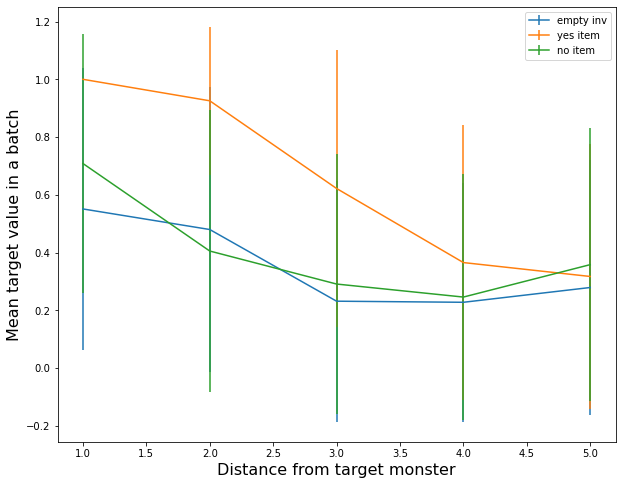

In [80]:
plt.figure(figsize=(10,8))
possible_distances = np.arange(1,6)

plt.errorbar(possible_distances, target_means[:,0], yerr=target_devs[:,0], label="empty inv")
plt.errorbar(possible_distances, target_means[:,1], yerr=target_devs[:,1], label="yes item")
plt.errorbar(possible_distances, target_means[:,2], yerr=target_devs[:,2], label="no item")
plt.xlabel("Distance from target monster", fontsize=16)
plt.ylabel("Mean target value in a batch", fontsize=16)
plt.legend()
plt.show()

## Same thing, but using bootstrapping with the predicted value of the last state

In [47]:
object_ids = torch.load("object_ids_Vboot1")
rb = torch.load("replay_buffer_Vboot1")
value_net = torch.load("value_net_Vboot1")

In [48]:
frames, targets = rb.get_batch(256)
value_means = np.zeros((5, 3))
value_devs = np.zeros((5, 3))
target_means = np.zeros((5, 3))
target_devs = np.zeros((5, 3))

for distance in range(0,5):
    print("\nDistance from target: ", distance+1)
    means, devs = full_distance_analysis(frames, targets, value_net, distance+1, object_ids)
    
    value_means[distance,0] = means["empty_values"]
    value_means[distance,1] = means["yes_values"]
    value_means[distance,2] = means["no_values"]
    target_means[distance,0] = means["empty_targets"]
    target_means[distance,1] = means["yes_targets"]
    target_means[distance,2] = means["no_targets"]
    value_devs[distance,0] = devs["empty_values"]
    value_devs[distance,1] = devs["yes_values"]
    value_devs[distance,2] = devs["no_values"]
    target_devs[distance,0] = devs["empty_targets"]
    target_devs[distance,1] = devs["yes_targets"]
    target_devs[distance,2] = devs["no_targets"]



Distance from target:  1
Rendering states with empty inventory
Mean predicted value: 0.83 +/- 0.31
Mean target value: 0.81 +/- 0.32
----------------------------------------
Rendering states with correct item in inventory
Mean predicted value: 1.09 +/- 0.06
Mean target value: 1.03 +/- 0.05
----------------------------------------
Rendering states with wrong item in inventory
Mean predicted value: 0.77 +/- 0.25
Mean target value: 0.74 +/- 0.28
----------------------------------------

Distance from target:  2
Rendering states with empty inventory
Mean predicted value: 0.82 +/- 0.35
Mean target value: 0.79 +/- 0.36
----------------------------------------
Rendering states with correct item in inventory
Mean predicted value: 1.09 +/- 0.08
Mean target value: 1.04 +/- 0.09
----------------------------------------
Rendering states with wrong item in inventory
Mean predicted value: 0.66 +/- 0.40
Mean target value: 0.64 +/- 0.41
----------------------------------------

Distance from target:  

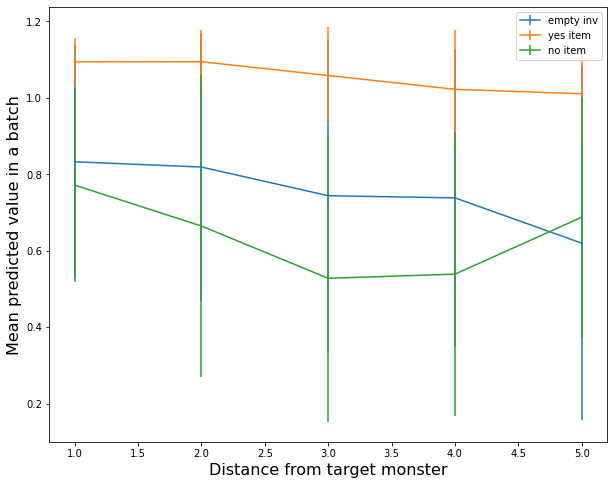

In [49]:
plt.figure(figsize=(10,8))
possible_distances = np.arange(1,6)

plt.errorbar(possible_distances, value_means[:,0], yerr=value_devs[:,0], label="empty inv")
plt.errorbar(possible_distances, value_means[:,1], yerr=value_devs[:,1], label="yes item")
plt.errorbar(possible_distances, value_means[:,2], yerr=value_devs[:,2], label="no item")
plt.xlabel("Distance from target monster", fontsize=16)
plt.ylabel("Mean predicted value in a batch", fontsize=16)
plt.legend()
plt.show()

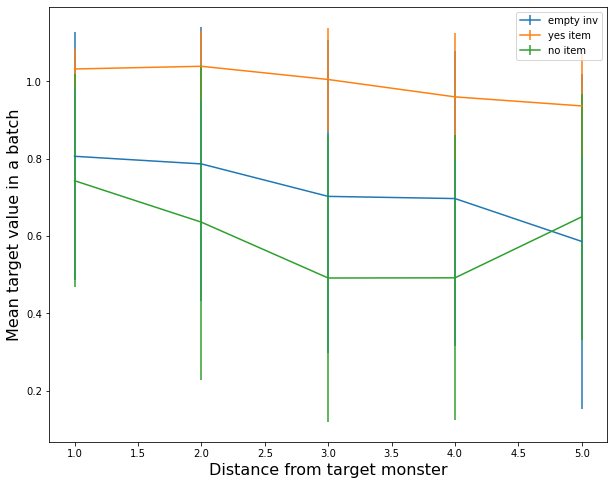

In [50]:
plt.figure(figsize=(10,8))
possible_distances = np.arange(1,6)

plt.errorbar(possible_distances, target_means[:,0], yerr=target_devs[:,0], label="empty inv")
plt.errorbar(possible_distances, target_means[:,1], yerr=target_devs[:,1], label="yes item")
plt.errorbar(possible_distances, target_means[:,2], yerr=target_devs[:,2], label="no item")
plt.xlabel("Distance from target monster", fontsize=16)
plt.ylabel("Mean target value in a batch", fontsize=16)
plt.legend()
plt.show()